In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from PIL import Image

IMAGE_DIR = "../fashion_images/dataset_clean"

images = []
image_paths = []

# iterate to call images data
for root, _, files in os.walk(IMAGE_DIR):
    for filename in files:
        if filename.lower().endswith(".jpg"):
            path = os.path.join(root, filename)
            image = Image.open(path).convert("RGB")
            images.append(image)
            image_paths.append(path)
    
print(f"Loaded {len(images)} JPG Images")

Loaded 8625 JPG Images


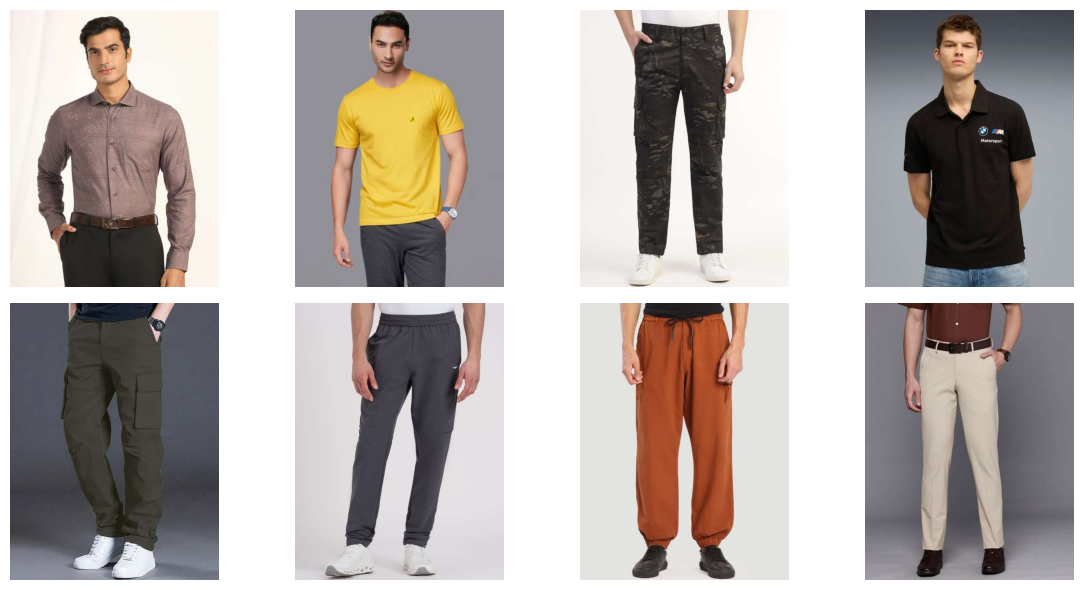

In [3]:
# Show random images

import random
import matplotlib.pyplot as plt

def show_random_images(images, n=8, cols=4, figsize=(12, 6)):
    n = min(n, len(images))
    selected = random.sample(images, n)

    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(selected):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage
show_random_images(images, n=8)

# Tensorflow deep learning model
# Purpose project:
### **Extracting images features to model which are integrated to business problem**
### * **enabling robust modeling of user preferences.**
### * **recommendation algorithms have progressively evolved from linear models to deep neural networks**
### * **multimodal deep learning framework that integrates visual, textual, and price features for business insight**
### * **Try to match outfit features top and bottom wearing (Optional task)**

In [5]:
# Load dataset and metadata
def load_file(parquet_path):
    df = pd.read_parquet(parquet_path)
    return df

pd.set_option('display.max_colwidth', None)
df = load_file("../data/matched_fashion_dataset.parquet")

# Features data matching

# Command
### Split data into numeric_cols and categorical_cols
### Normalize Numeric Features
### Encode Categorical Features
### Image Loading Pipeline (TF-Native & Scalable)
### Build tf.data.Dataset (MANDATORY)
    Purpose
    • Streaming
    • Shuffling
    • GPU utilization
    • Reliability

### Define Image Encoder (tensorflow.keras, ResNet50)
### Define Metadata Encoder (MLP + Embeddings)
### Joint Embedding Head (CORE MODEL)
### Final Model (Embedding Model)
### Loss Function (WHY THIS WORKS) -> Use self-supervised similarity.
### Train model
### Generate Embeddings (predict use model toward on data)

## Split data

In [ ]:
import tensorflow as tf

NUMERIC_COLS = [
    "price",
    "length_cm",
    "view_count",
    "click_count",
    "purchase_count",
]

CATEGORICAL_COLS = [
    "category",
    "subcategory",
    "brand",
    "sleeve_type",
]

## Normalize Numeric Features

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Normalize numeric columns using RobustScaler for deep learning
scaler = StandardScaler()
X_num = scaler.fit_transform(df[NUMERIC_COLS].fillna(0))

print("Numeric features shape:", X_num.shape)

Numeric features shape: (1100000, 5)


# Data encoding for categorical features

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
X_cat = {}

for col in CATEGORICAL_COLS:
    """Encoding for categorial features"""
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

X_cat = pd.DataFrame(X_cat)

In [ ]:
X_cat

,category,subcategory,brand,sleeve_type
0,0,4,4,0
1,1,2,1,0
2,1,2,1,0
3,1,6,4,1
4,1,2,5,0
...,...,...,...,...
1099995,1,7,1,1
1099996,0,1,3,0
1099997,0,4,0,0
1099998,1,7,4,1


## Image Loading Pipeline (TF-Native & Scalable)

In [ ]:
def load_image(path):
    """Load and preprocess image"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0  # Normalize to [0, 1]
    return img

## Create assumtion based High Performer vs Low Performer

In [ ]:
# Top 30% engagement score threshold
engagement_score = (
    df['purchase_count'] * 10 +
    df['click_count'] * 2 +
    df['view_count'] * 1
)

threshold = engagement_score.quantile(0.7)
y_target = (engagement_score >= threshold).astype(float).values
print(f"Target distribution - Positive: {y_target.mean():.2%}, Negative: {(1-y_target).mean():.2%}")

Target distribution - Positive: 30.03%, Negative: 69.97%


## Build tf.data.Dataset

In [ ]:
# FIXED: Create function to build tf.data.Dataset
def build_dataset(df, X_cat, X_num, y_target, batch_size=256):
    """Build tf.data.Dataset for getting data into Tensorflow model"""
    ds = tf.data.Dataset.from_tensor_slices({
        "image_path": df["image_path"].values,
        "numeric": X_num,
        "category": X_cat["category"].values,
        "subcategory": X_cat["subcategory"].values,
        "brand": X_cat["brand"].values,
        "sleeve_type": X_cat["sleeve_type"].values,
        "target": y_target
    })
    ds = ds.map(lambda x: (
        {
            "image": load_image(x["image_path"]),
            "numeric": x["numeric"],
            "category": x["category"],
            "subcategory": x["subcategory"],
            "brand": x["brand"],
            "sleeve_type": x["sleeve_type"],
        },
        x["target"]
    ), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # FIXED: Changed batch(batch_size=batch_size) to batch(batch_size)

## Define Image Encoder (CNN Backbone)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model

# Clear any previous models
tf.keras.backend.clear_session()

image_input = layers.Input(shape=(224, 224, 3), name="image")
base_cnn = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_tensor=image_input)
base_cnn.trainable = False # Start frozen

image_emb = base_cnn(image_input)
image_emb = layers.Dense(256, activation="relu")(image_emb)

2026-02-12 16:46:39.009819: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-12 16:46:39.009926: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-12 16:46:39.009937: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-12 16:46:39.010146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-12 16:46:39.010629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Define Metadata Encoder (MLP + Embeddings)

In [ ]:
num_input = layers.Input(shape=(len(NUMERIC_COLS),), name="numeric")
num_emb = layers.Dense(64, activation="relu")(num_input)

def cat_emb(name, vocab_size, dim=16):
    inp = layers.Input(shape=(1, ), name=name)
    emb = layers.Embedding(input_dim=vocab_size, output_dim=dim)(inp)
    return inp, layers.Flatten()(emb)

cat_inputs = []
cat_embeddings = []

for col in CATEGORICAL_COLS:
    inp, emb = cat_emb(col, len(encoders[col].classes_))
    cat_inputs.append(inp)
    cat_embeddings.append(emb)

## Final Model (Embedding Model)

In [ ]:
# Joint embedding
embedding = layers.Concatenate()([image_emb, num_emb] + cat_embeddings)

output = layers.Dense(1, activation="sigmoid", name='recommended_score')(embedding)

# Build model with output layer
model = tf.keras.Model(
    inputs=[image_input, num_input] + cat_inputs,
    outputs=output
)

# Verify model summary
for inp in model.inputs:
    print(f" {inp.name}: {inp.shape}")

 image: (None, 224, 224, 3)
 numeric: (None, 5)
 category: (None, 1)
 subcategory: (None, 1)
 brand: (None, 1)
 sleeve_type: (None, 1)


## Increased accuracy score with numpy

### TODO: using val_ds in model.fit() on training models to ensure increasingly accuracy
    Notes: Recommended if having much time for training, not recommended if want to go production fastly


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Split data into train and validation
train_idx, val_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42, stratify=y_target)

# Create datasets
train_ds = build_dataset(
    df.iloc[train_idx].reset_index(drop=True),
    X_cat.iloc[train_idx].reset_index(drop=True),
    X_num[train_idx],
    y_target[train_idx]
)

val_ds = build_dataset(
    df.iloc[val_idx].reset_index(drop=True),
    X_cat.iloc[val_idx].reset_index(drop=True),
    X_num[val_idx],
    y_target[val_idx]
)

## Loss Function (WHY THIS WORKS)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
   optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
   loss="binary_crossentropy", # Try loss = "binary_crossentropy" later if we want to checklist fashion attributes
   metrics=["accuracy", "AUC"]
)

# Create EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='loss', # Using validation data loss so use monitor as val_loss
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
train_ds = build_dataset(df, X_cat, X_num, y_target)

history = model.fit(train_ds,
          #validation_data=val_ds,
          epochs=10,
          steps_per_epoch=120, # Step per 1 epoch is gaining 120 steps -> if epoch = 10, total steps = 1200
          callbacks=[early_stopping],
          verbose=1
         )

# After training, create embedding extractor model
embedding_model = tf.keras.Model(
    inputs=model.inputs, 
    outputs=model.get_layer('concatenate').output # Get the concatenated embedding layer output
)

print("Model trained and embedding extractor created.")
print("=" * 40)

# Check validation accuracy
"""try not to put val_ds first in the training"""
#vaL_predictions = model.predict(val_ds, steps=20)
#val_pred_binary = (vaL_predictions > 0.5).astype(int).flatten()
#val_accuracy = accuracy_score(y_target[val_idx], val_pred_binary)

#print(f"\n📊 Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

Epoch 1/10


2026-02-12 16:46:45.915886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 445s 4s/step - loss: 0.5935 - accuracy: 0.7051 - auc: 0.6100
Epoch 2/10
120/120 [==============================] - 407s 3s/step - loss: 0.5350 - accuracy: 0.7157 - auc: 0.8647
Epoch 3/10
120/120 [==============================] - 404s 3s/step - loss: 0.4874 - accuracy: 0.7441 - auc: 0.9462
Epoch 4/10
120/120 [==============================] - 396s 3s/step - loss: 0.4418 - accuracy: 0.7819 - auc: 0.9730
Epoch 5/10
120/120 [==============================] - 394s 3s/step - loss: 0.3987 - accuracy: 0.8197 - auc: 0.9813
Epoch 6/10
120/120 [==============================] - 402s 3s/step - loss: 0.3592 - accuracy: 0.8505 - auc: 0.9868
Epoch 7/10
120/120 [==============================] - 393s 3s/step - loss: 0.3282 - accuracy: 0.8726 - auc: 0.9905
Epoch 8/10
120/120 [==============================] - 390s 3s/step - loss: 0.2995 - accuracy: 0.8910 - auc: 0.9920
Epoch 9/10
120/120 [==============================] - 401s 3s/step - loss: 0.2766 - accurac

'try not to put val_ds first in the training'

## Save models

In [ ]:
# Save the full model (with classification head)
model.save('fashion_recommendation_model.keras')
print("✅ Full model saved as 'fashion_recommendation_model.keras'")

# Save the embedding extractor separately
embedding_model.save('fashion_embedding_model.keras')
print("✅ Embedding model saved as 'fashion_embedding_model.keras'")


✅ Full model saved as 'fashion_recommendation_model.keras'
✅ Embedding model saved as 'fashion_embedding_model.keras'


## Make predictions

In [ ]:
# Prepare test data
test_ds = build_dataset(df.head(100), X_cat.head(100), X_num[:100], y_target[:100])

# Predict recommendation scores
predictions = model.predict(test_ds, steps=5, verbose=1)
print(f"\nPrediction shape: {predictions.shape}")
print(f"Sample predictions (first 10):")
print(predictions[:10].flatten())

# Convert to binary (recommend or not)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int).flatten()
print(f"\nBinary predictions (first 10): {binary_predictions[:10]}")

# --- OPTION B: Generate embeddings for similarity search ---
# Extract embeddings
embeddings = embedding_model.predict(test_ds, steps=10, verbose=1)
print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Sample embedding (first item, first 10 dims): {embeddings[0][:10]}")

5/5 [==============================] - 2s 95ms/step

Prediction shape: (100, 1)
Sample predictions (first 10):
[0.47523034 0.9970009  0.30557746 0.45558628 0.6149004  0.08390799
 0.2545658  0.03550152 0.0283134  0.11944313]

Binary predictions (first 10): [0 1 0 0 1 0 0 0 0 0]
10/10 [==============================] - 1s 4ms/step

Embedding shape: (100, 384)
Sample embedding (first item, first 10 dims): [ 0.24000667  0.25672987 -0.5025847  -1.4420242  -1.3362796  -0.24923818
  0.8297239  -0.4179338   0.77617705  0.28923243]


In [ ]:
# Load embedding model

load_embed = tf.keras.models.load_model('fashion_embedding_model.keras')
load_embed.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 category (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 subcategory (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 brand (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            